In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [45]:
df = pd.read_csv('https://raw.githubusercontent.com/Padam-0/cluster_t-shirt_sizing/master/data.csv') 

#remove_cols = []

#for i in df.columns:
#    if 3900 - df.loc[:,i].astype(bool).sum() > 2000:
#        remove_cols.append(i)
#print(df.shape)
#df = df.drop(remove_cols, axis = 'columns')

df.head()

,PERSON #,WEIGHT,STATURE,VERTICAL GRIP REACH,FRONTAL GRIP REACH,LATERAL GRIP REACH,STEP HEIGHT,SUPINE STATURE,STANDING CENTER OF GRAVITY,ERECT SITTING HEIGHT,...,BIRTH ORDER,MOTHERS OCCUPATION,FATHERS OCCUPATION,MOTHERS EDUCATION,FATHERS EDUCATION,YEARS IN COMMUNITY,COMMENT CODES,ANTHROPOMETER NO,CALIPER NO,GIRTH NO
0,Person #1,155,1033,0,0,0,0,0,0,582,...,1,7,7,4,4,23,0,1,0,1
1,Person #2,176,1039,1238,518,651,420,0,0,606,...,1,7,7,4,4,7,0,1,0,1
2,Person #3,230,1112,0,0,0,0,0,0,594,...,1,7,7,4,4,6,0,1,0,1
3,Person #4,165,997,1146,496,0,350,0,0,542,...,1,11,9,3,4,4,0,1,0,1
4,Person #5,150,997,0,0,0,0,0,0,524,...,1,7,7,4,4,5,0,1,0,1


In [46]:
df.SEX.head()

0    2
1    1
2    2
3    2
4    2
Name: SEX, dtype: int64

In [49]:
# Intuiting useful features for shirt size
df = df.loc[:, ['ERECT SITTING HEIGHT', 'WEIGHT', 'HEAD CIRCUMFERENCE', 'SEX', 'SHOULDER BREADTH', 'AGE IN MONTHS', 'CHEST CIRCUMFERENCE']]

#def binary_gender(series):
 #   for i in series:
  #      if i == 1:
   #         return 0
    #    else:
     #       return 1

#df['SEX'] = df['SEX'].apply(binary_gender(df['SEX'])
#df['SEX'].head()
# I could try a naive linear regression before 
# Recode sex to 0 and 1
df.head()

,ERECT SITTING HEIGHT,WEIGHT,HEAD CIRCUMFERENCE,SEX,SHOULDER BREADTH,AGE IN MONTHS,CHEST CIRCUMFERENCE
0,582,155,498,2,282,50,526
1,606,176,506,1,273,51,564
2,594,230,512,2,309,53,601
3,542,165,489,2,253,46,532
4,524,150,473,2,273,41,501


In [50]:
# Removing zeroes, since this dataframe shouldn't have any.
df = df.loc[(df != 0).all(1)]
df.describe()

,ERECT SITTING HEIGHT,WEIGHT,HEAD CIRCUMFERENCE,SEX,SHOULDER BREADTH,AGE IN MONTHS,CHEST CIRCUMFERENCE
count,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000,3749.000000
mean,735.682315,373.609229,529.492131,1.487330,338.769005,125.508936,696.897039
std,111.377262,177.847074,25.222918,0.499906,61.444533,53.036628,130.591514
min,468.000000,101.000000,452.000000,1.000000,193.000000,24.000000,434.000000
25%,649.000000,220.000000,512.000000,1.000000,288.000000,79.000000,587.000000
50%,735.000000,344.000000,529.000000,1.000000,337.000000,129.000000,688.000000
75%,825.000000,504.000000,546.000000,2.000000,385.000000,169.000000,795.000000
max,996.000000,1123.000000,613.000000,2.000000,518.000000,240.000000,1123.000000


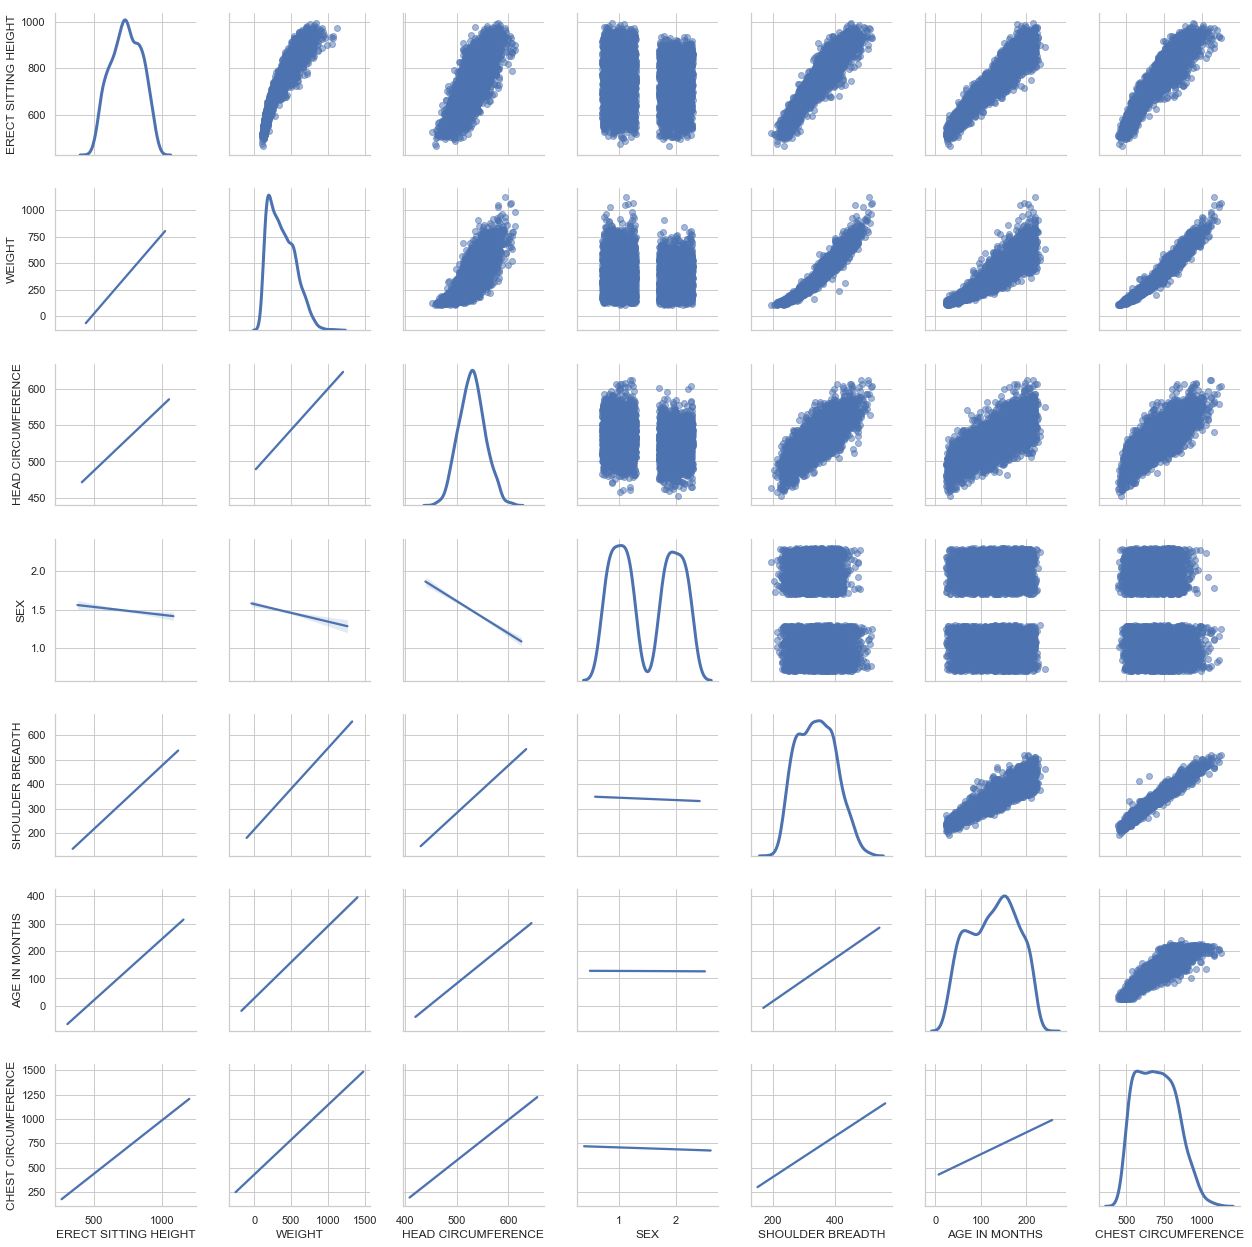

In [51]:
# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:, 'ERECT SITTING HEIGHT':'CHEST CIRCUMFERENCE'].dropna()
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

## We see some linear relationships, and mostly unimodal distribution.

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'SHOULDER BREADTH and Age')

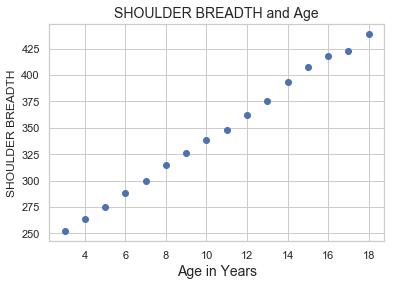

In [52]:
shoulder_data = df[['SHOULDER BREADTH', 'AGE IN MONTHS']]
shoulder_data['YEAR'] = shoulder_data['AGE IN MONTHS'].apply(lambda x: x//12)
x = list(shoulder_data.groupby('YEAR').mean().index[1:-2])
y = list(shoulder_data.groupby('YEAR').mean()['SHOULDER BREADTH'][1:-2])

plt.scatter(x, y, data=shoulder_data)
#plt.xticks([])
plt.xlabel('Age in Years',fontsize=14)
plt.ylabel('SHOULDER BREADTH')
plt.title('SHOULDER BREADTH and Age',fontsize=14)

Text(0.5,1,'Weight and Age')

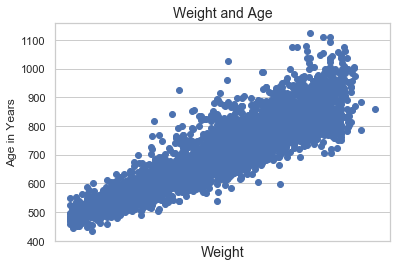

In [53]:
y = df['CHEST CIRCUMFERENCE']
x = df['AGE IN MONTHS']

plt.scatter(x, y, data=df)
plt.xticks([])
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Age in Years')
plt.title('Weight and Age',fontsize=14)

C:\Users\Zack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Weight and Age')

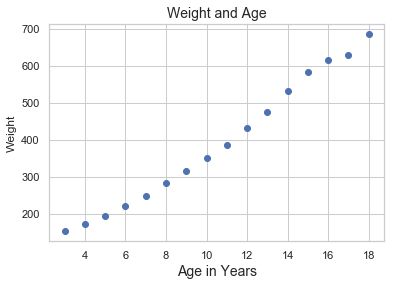

In [54]:
weight_data = df[['WEIGHT', 'AGE IN MONTHS']]
weight_data['YEAR'] = weight_data['AGE IN MONTHS'].apply(lambda x: x//12)
x = list(weight_data.groupby('YEAR').mean().index[1:-2])
y = list(weight_data.groupby('YEAR').mean()['WEIGHT'][1:-2])

plt.scatter(x, y, data=weight_data)
#plt.xticks([])
plt.xlabel('Age in Years',fontsize=14)
plt.ylabel('Weight')
plt.title('Weight and Age',fontsize=14)

                      ERECT SITTING HEIGHT    WEIGHT  HEAD CIRCUMFERENCE  \
ERECT SITTING HEIGHT              1.000000  0.937958            0.790818   
WEIGHT                            0.937958  1.000000            0.806637   
HEAD CIRCUMFERENCE                0.790818  0.806637            1.000000   
SEX                              -0.041717 -0.077603           -0.208725   
SHOULDER BREADTH                  0.940299  0.968519            0.802928   
AGE IN MONTHS                     0.946025  0.896742            0.735119   
CHEST CIRCUMFERENCE               0.934856  0.976569            0.809261   

                           SEX  SHOULDER BREADTH  AGE IN MONTHS  \
ERECT SITTING HEIGHT -0.041717          0.940299       0.946025   
WEIGHT               -0.077603          0.968519       0.896742   
HEAD CIRCUMFERENCE   -0.208725          0.802928       0.735119   
SEX                   1.000000         -0.084082      -0.004376   
SHOULDER BREADTH     -0.084082          1.000000       0

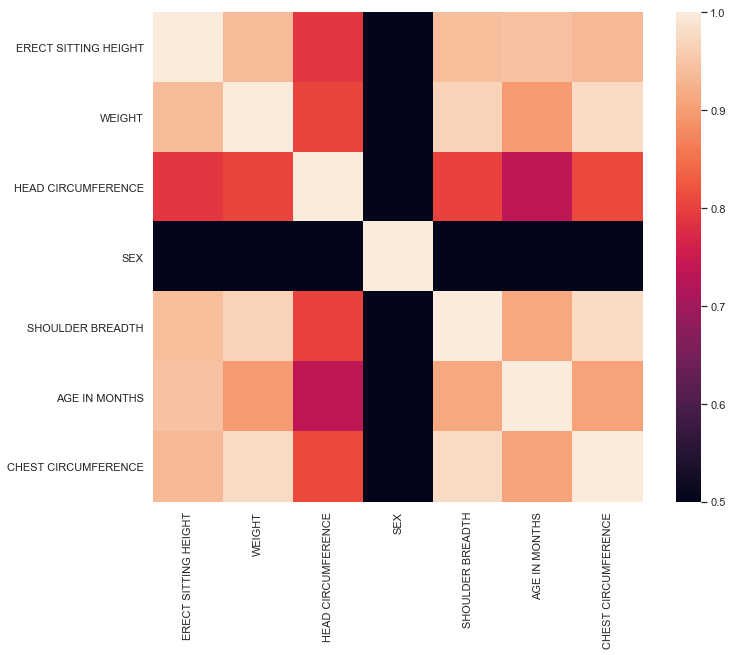

In [55]:
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmin=.5, vmax=1, square=True)
plt.show()

## My dataframe variables are highly correlated, except for SEX. Time for some PCA.

## Prinicpal component 1 explains 96.4% of the variance in the datset. 

In [71]:
from sklearn.decomposition import PCA
X = df.loc[:, ['ERECT SITTING HEIGHT', 'WEIGHT', 'HEAD CIRCUMFERENCE', 'SEX', 'SHOULDER BREADTH', 'AGE IN MONTHS', 'CHEST CIRCUMFERENCE']]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()



,principal component 1,principal component 2
0,-331.039496,19.894111
1,-288.714125,17.462131
2,-228.647296,57.520305
3,-346.181995,58.183250
4,-377.172795,61.637350


The percentage of total variance in the dataset explained by each component from PCA.
 [0.96455908 0.01907006]


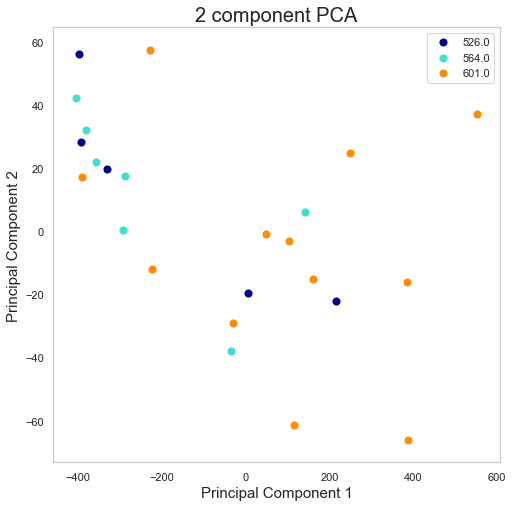

In [58]:
finalDf = pd.concat([principalDf, df[['CHEST CIRCUMFERENCE']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = finalDf['CHEST CIRCUMFERENCE']
colors = ['navy', 'turquoise', 'darkorange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['CHEST CIRCUMFERENCE'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
              #label=target_name)
ax.legend(targets)
ax.grid()

print(
    'The percentage of total variance in the dataset explained by each',
    'component from PCA.\n',
    pca.explained_variance_ratio_
)

In [59]:
# Linear Regression on PCA
from sklearn import linear_model

# Instantiate and fit our model.
regr = linear_model.LinearRegression()

X = principalComponents
Y = df['CHEST CIRCUMFERENCE'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[0.50286134 0.20848223]]

Intercept: 
 [696.89703921]

R-squared:
0.9803351194229923


## PCA Linear Regression seems to perform well.

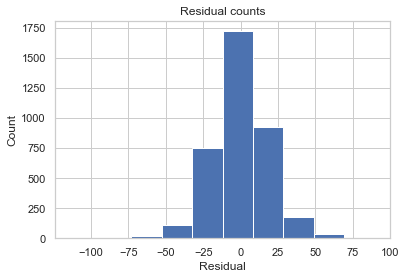

In [60]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['CHEST CIRCUMFERENCE']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

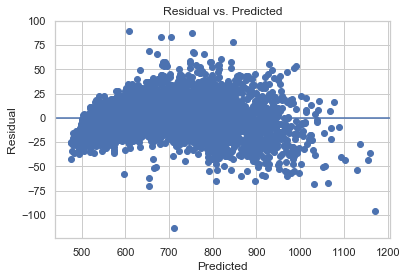

In [61]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### I need to tighten this up, but don't know how. Should I normalize the outcome variable with boxcox?

In [63]:
# Cross validation

targets = df['CHEST CIRCUMFERENCE']

from sklearn.model_selection import cross_val_score
cross_val_score(regr,principalComponents, targets, cv=10)

array([0.97632823, 0.97921555, 0.9723266 , 0.97467785, 0.98269998,
       0.97084958, 0.983173  , 0.97845304, 0.96329791, 0.98543885])

In [64]:
#from scipy.stats import boxcox
#Z = df['CHEST CIRCUMFERENCE']

#boxcox_transformed_data = boxcox(Z)

#boxcox_transformed_data 


In [65]:
from sklearn.model_selection import cross_val_predict

#Define a training sizes
#trainsize = int(df.shape[0] / 2)
X = principalComponents
Y = df['CHEST CIRCUMFERENCE'].values.reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)
#df_test = df.iloc[trainsize:, :].copy()
#df_train = df.iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
regr1.fit(X_train, Y_train)
print('\nR-squared:')
print(regr1.score(X_train, Y_train))

score = cross_val_score(regr1, X_train, Y_train, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)
#print(cross_val_predict(regr1, X_train, Y_train, cv=10))


R-squared:
0.9803550615442238

Mean (SD) Cross Validation Score: 0.98 (+/- 0.01)

Cross Validation Scores:
[0.97656568 0.98113531 0.98507104 0.98066691 0.98112376 0.98065661
 0.98073465 0.97809251 0.98205957 0.97561679]


## The PCA Linear Regression performs well even with a 33% testing holdout.

Coefficients: 
 [[0.50383834 0.20775961]]
Mean squared error: 332.38
Variance score: 0.98


ValueError: x and y must be the same size

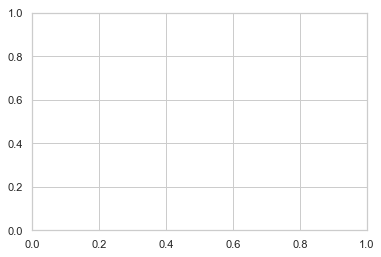

In [66]:
# Can't get this to work :(

from sklearn.metrics import mean_squared_error, r2_score

# Make predictions using the testing set
Y_pred = regr1.predict(X_test)

# The coefficients
print('Coefficients: \n', regr1.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, Y_pred))

# Plot outputs
plt.scatter(X_test, Y_test,  color='black')
plt.plot(X_test, Y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [67]:
#Define a training sizes
#trainsize = int(df.shape[0] / 2)
X = df.loc[:, ['ERECT SITTING HEIGHT', 'WEIGHT', 'HEAD CIRCUMFERENCE', 'SEX', 'SHOULDER BREADTH', 'AGE IN MONTHS']]
Y = df['CHEST CIRCUMFERENCE'].values.reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print('\nR-squared:')
print(ridgeregr.score(X_train, Y_train))

# Cross validation

score = cross_val_score(ridgeregr, X_train, Y_train, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)



R-squared:
0.970265949066709

Mean (SD) Cross Validation Score: 0.97 (+/- 0.01)

Cross Validation Scores:
[0.96723421 0.96784189 0.97905935 0.96731248 0.97190516 0.97268785
 0.96554592 0.96817261 0.97126609 0.96733965]


## Ridge seems slighlty worse than the PCA Linear Regression.

In [68]:
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))

# Cross validation

score = cross_val_score(lassfit, X_train, Y_train, cv=10)

print("\nMean (SD) Cross Validation Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
print('\nCross Validation Scores:')
print(score)


R² for the model with few features:
0.9711159403064715

Mean (SD) Cross Validation Score: 0.97 (+/- 0.01)

Cross Validation Scores:
[0.96767355 0.96753639 0.97980742 0.9686851  0.97295644 0.97365872
 0.9668423  0.96967077 0.97253817 0.96776044]


## Lasso seems slightly better than Ridge.

In [69]:
#Random Forest model

from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
X = df.loc[:, ['ERECT SITTING HEIGHT', 'WEIGHT', 'HEAD CIRCUMFERENCE', 'SEX', 'SHOULDER BREADTH', 'AGE IN MONTHS']]
Y = df['CHEST CIRCUMFERENCE']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

rfc.fit(X,Y)
cross_val_score(rfc, X, Y, cv=10)



C:\Users\Zack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Zack\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.0152439 , 0.01624549, 0.01417004, 0.00904977, 0.00777202,
       0.00892857, 0.01677852, 0.0242915 , 0.02072539, 0.02797203])

Feature ranking:
1. feature 1 (0.205116)
2. feature 0 (0.191147)
3. feature 2 (0.190463)
4. feature 5 (0.187820)
5. feature 4 (0.183741)
6. feature 3 (0.041713)


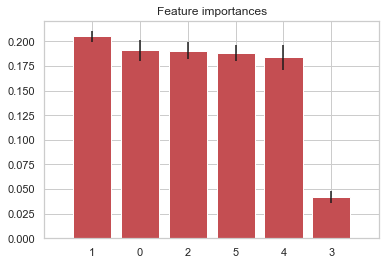

In [70]:
# Random Forest feature ranking.

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
     #  names = list(data.keys()))
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Random forets features don't seem too important. 

In [23]:
#from scipy.stats import boxcox
#Z = df2['CHEST CIRCUMFERENCE']

#boxcox_transformed_data = boxcox(Z)